# Make multi_anim_sess dictonary:

### Groups sess data from multiple animals on a single day, and calculates dFF, place cells, and trial set dictionary

pickle files will be named: \
`<animal-numbers>_expday<day_number>_speed<thr>_perms<nperms>_<dff-baseline-method>_<timeseries-for-place-cells>.pickle`  \
and saved in `path_dict['preprocessed_root']/multi_anim_sess/`.

For example, if the animals' original names were GCAMP4, GCAMP5, GCAMP6, the file will be:  \
`4-5-6_expday1_speed2_perms100_maximin_events.pickle`
for the 1st experiment day (1-indexed), with the following parameters:
* speed threshold >2 cm/s for data included to calculate place cells
   * NOTE: trial matrices in ['sess'] are still the originals stored in the `sess` of each animal,  \
   with data from all speeds included
* 100 permutations for spatial information shuffle
* maximin dFF baseline method
* deconvolved 'events' were used to calculate place cells

addition parameters are saved in `['params']` of the dict.

See utilities.multi_anim_sess for more.

In [1]:
import os
import pickle
import numpy as np
import warnings

from reward_relative import utilities as ut
from reward_relative import dayData as dd
from reward_relative import teleport_metadata 

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from reward_relative.path_dict_firebird import path_dictionary as path_dict

In [3]:
path_dict

{'preprocessed_root': '/data/2P',
 'sbx_root': '/mnt/oak/InVivoDA/2P_Data',
 'gdrive_root': '/mnt/gdrive/2P_Data',
 'VR_Data': '/data/2P/VR_Data',
 'git_repo_root': '/home/mari/local_repos/2p_repos',
 'TwoPUtils': '/home/mari/local_repos/2p_repos/TwoPUtils',
 'home': '/home/mari',
 'fig_dir': '/data/2P/fig_scratch'}

In [12]:
tele_sessions = teleport_metadata.teleport_sessions
tele_sessions

{'GCAMP10': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP11': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP12': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP13': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP14': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP15': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]},
 'GCAMP17': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]},
 'GCAMP18': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]},
 'GCAMP19': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]}}

In [ ]:
save_pkl = False # SET TO TRUE TO SAVE TO DISK

experiment = 'MetaLearn'
year = 'combined' #2023 contains first 7 switch animals, 2024 contains last 4 switch animals

exp_days = [3, 5, 7, 8, 10, 12, 14] # switch days

trial_subsets = True  # whether to split place cell calc by subsets of trials
# if set to True but only 1 trial type, takes 1st and 2nd half of trials
shuffle_method = 'population'  # 'population' or 'individual'

params = {'speed_thr': 2,  # speed threshold for place cells
          'nperms': 100,
          'output_shuffle': False,
          'shuffle_method': shuffle_method,
          'p_thr':  0.05,  # p value threshold
          'stability_thr': None,
          'ts_key': 'events',  # timeseries to use for place cell detection
          'trial_subsets': trial_subsets,
          'min_subtract': False,
          }

baseline_method = 'maximin'


collect_anim_list = {}

for exp_day in exp_days:

    anim_list = dd.define_anim_list(experiment, exp_day, year=year)
    
    # find whether to keep dFF in teleport periods by animal (whether or not laser was blanked)
    keep_teleports = np.zeros((len(anim_list),)).astype(bool)
    for an in anim_list:
        if an in tele_sessions.keys():
            if exp_day in tele_sessions[an]['exp_days']:
                keep_teleports[np.where(anim_list==an)[0][0]] = True
        else:
            keep_teleports[np.where(anim_list==an)[0][0]] = False
    
    dff_method = {'neuropil_method_red': 'subtract',
              'neuropil_method_green': None,
              'baseline_method': baseline_method,
              'regress_g_from_r': False,
              'regress_r_from_g': False,
              'neu_coef': 0.7,
             'keep_teleports': keep_teleports}

    anim_tag = "-".join([ut.get_mouse_number(s) for s in anim_list])
    print(anim_tag)

    multi_anim_sess = {}
    collect_anim_list[exp_day] = anim_list

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        multi_anim_sess = ut.multi_anim_sess(path_dict, 
                                      anim_list, 
                                      exp_day,
                                      calc_dff=True, 
                                      calc_pcs=True,
                                      calc_spks=True,
                                      ts_key=params['ts_key'],
                                      dff_method=dff_method,
                                      speed_thr=params['speed_thr'],
                                      trial_subsets=params['trial_subsets'],
                                      nperms=params['nperms'],
                                      output_shuffle=params['output_shuffle'],
                                      p_thr=params['p_thr'],
                                      stability_thr=params['stability_thr'],
                                      bin_size=10,
                                      min_pos=0,
                                      max_pos=450,
                                      shuffle_method=params['shuffle_method'],
                                      )

        multi_anim_sess['params'] = params
        multi_anim_sess['dff_method'] = dff_method
        multi_anim_sess['anim_list'] = anim_list

    if save_pkl:
        # Optional save:
        pkl_dir = os.path.join(
            path_dict['preprocessed_root'], 'multi_anim_sess')
        os.makedirs(pkl_dir, exist_ok=True)

        if params['output_shuffle']:
            pkl_name = '%s_expday%d_speed%s_perms%d_%s_%s_w-shuffle.pickle' % (anim_tag,
                                                                               exp_day,
                                                                               str(
                                                                                   params['speed_thr']),
                                                                               params['nperms'],
                                                                               baseline_method,
                                                                               params['ts_key'])
        else:
            pkl_name = '%s_expday%d_speed%s_perms%d_%s_%s.pickle' % (anim_tag,
                                                                     exp_day,
                                                                     str(params['speed_thr']),
                                                                     params['nperms'],
                                                                     baseline_method,
                                                                     params['ts_key'])

        print(pkl_dir, pkl_name)
        # Write sess to pickle file

        ut.write_sess_pickle(multi_anim_sess, pkl_dir, pkl_name, overwrite=True)

# Get full animal list
tmp_list = np.unique(np.concatenate(
    [collect_anim_list[d] for d in exp_days]
))
max_anim_list = sorted(tmp_list, key=len)
print(max_anim_list)
max_anim_tag = "-".join([ut.get_mouse_number(s) for s in max_anim_list])

In [19]:
multi_anim_sess.keys()

dict_keys(['GCAMP2', 'GCAMP3', 'GCAMP4', 'GCAMP5', 'GCAMP6', 'GCAMP7', 'GCAMP10', 'GCAMP11', 'GCAMP12', 'GCAMP13', 'GCAMP14', 'GCAMP15', 'GCAMP17', 'GCAMP18', 'GCAMP19', 'params', 'dff_method', 'anim_list'])

# Check which animals have teleport data

In [25]:
from matplotlib import pyplot as plt

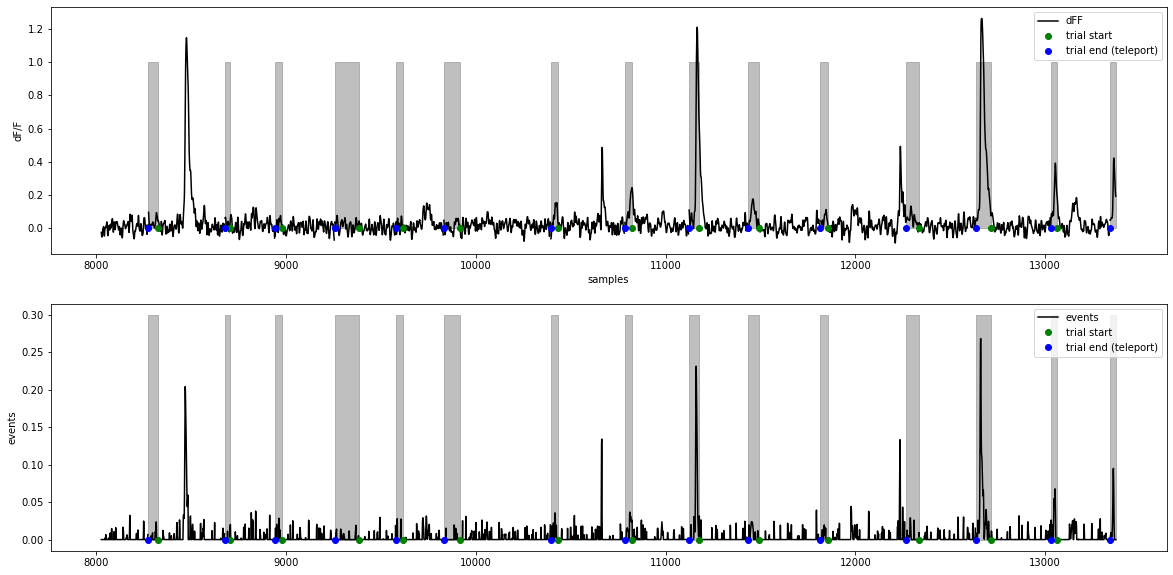

In [27]:
# Plot to check updated dff (on last day run)
roi=60 #example ROI, choose arbitrarily
an = 'GCAMP18'

dFF = np.copy(multi_anim_sess[an]['sess'].timeseries['dff'])
events = np.copy(multi_anim_sess[an]['sess'].timeseries['events'])
trial_starts = np.copy(multi_anim_sess[an]['sess'].trial_start_inds)
teleports = np.copy(multi_anim_sess[an]['sess'].teleport_inds)

nan_inds = np.isnan(dFF[roi,:])
_c = multi_anim_sess[an]['sess'].vr_data['time'].values[~nan_inds]
_m = dFF[roi,~nan_inds]

fig, ax  = plt.subplots(2,1,figsize=[20,10])


ind0 = trial_starts[25] #sess.trial_start_inds[29]
ind1 = trial_starts[40] #sess.teleport_inds[29]
ax[0].plot(np.arange(ind0, ind1),dFF[roi,ind0:ind1],'k',label="dFF");

tstarts = trial_starts[(trial_starts>ind0)] # & (trial_starts<ind1)]
for tend_i, tend in enumerate(teleports[(teleports>ind0) & (teleports<ind1)]):
    closest_start = tstarts[ut.lookup_ind_bigger(tend,tstarts)]
    ax[0].fill_betweenx([0,1],tend,closest_start, color='grey', alpha=0.5) 
    
[ax[0].plot(tstart,0,'go') for tstart in trial_starts[(trial_starts>ind0) & (trial_starts<ind1)] ];
ax[0].plot(np.nan,0,'go', label='trial start')
ax[0].plot(np.nan,0,'bo', label='trial end (teleport)')
[ax[0].plot(tend,0,'bo') for tend in teleports[(teleports>ind0) & (teleports<ind1)] ];
# ax[1].plot(trial_starts[30],0,'X',markersize=20,color='red')
ax[0].set_ylabel('dF/F')
ax[0].set_xlabel('samples')

ax[1].plot(np.arange(ind0, ind1),events[roi,ind0:ind1], 'black',label="events");
# ax[3].plot(np.arange(ind0, ind1),(sig_events*thresh)[ind0:ind1], '.m',label='2sd thresh')
for tend_i, tend in enumerate(teleports[(teleports>ind0) & (teleports<ind1)]):
    closest_start = tstarts[ut.lookup_ind_bigger(tend,tstarts)]
    ax[1].fill_betweenx([0,0.3],tend,closest_start, color='grey', alpha=0.5) 
    
[ax[1].plot(tstart,0,'go') for tstart in trial_starts[(trial_starts>ind0) & (trial_starts<ind1)] ];
ax[1].plot(np.nan,0,'go', label='trial start')
ax[1].plot(np.nan,0,'bo', label='trial end (teleport)')
[ax[1].plot(tend,0,'bo') for tend in teleports[(teleports>ind0) & (teleports<ind1)] ];
ax[1].set_ylabel('events')

ax[0].legend()
ax[1].legend()

# Even when teleports were imaged, there are still a couple nan values at the samples
# where the teleport itself happens, as the position value at this sample is unreliable 
# (it will be somewhere between 450 and -50, interpolating between the last position
# on the track and the first position in the teleport "tunnel"

## (Optional) Combine and save multi_anim_sess specifically for animals and days with teleport data

In [18]:
from reward_relative import teleport_metadata 
tele_sessions = teleport_metadata.teleport_sessions
tele_sessions

{'GCAMP10': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP11': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP12': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP13': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP14': {'exp_days': [1, 7, 8, 14, 15]},
 'GCAMP15': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]},
 'GCAMP17': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]},
 'GCAMP18': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]},
 'GCAMP19': {'exp_days': [1, 3, 5, 7, 8, 10, 12, 14, 15, 16, 17]}}

In [9]:
np.unique(np.concatenate([tele_sessions[an]['exp_days'] for an in tele_sessions.keys()]))

array([ 1,  3,  5,  7,  8, 10, 12, 14, 15, 16, 17])

In [32]:

exp_days = [1,  3,  5,  7,  8, 10, 12, 14]
experiment = 'MetaLearn'
save_pkl = True

total_anim_list = np.asarray(list(tele_sessions.keys()))

params={'speed': '2',
       'nperms': 100,
       'baseline_method': 'maximin',
       'ts_key': 'events'
       }


for exp_day in exp_days:
    print('exp day', exp_day)
    super_multi_anim_sess = dict([(an, {}) for an in total_anim_list])
    super_multi_anim_sess['params'] = params
    
    if exp_day in [1,7,8,14]:
        
        anim_list_1 = np.asarray(list(tele_sessions.keys()))[:5]
        if exp_day == 1:
            anim_list_1 = anim_list_1[anim_list_1!='GCAMP11']
        anim_list_2 = np.asarray(list(tele_sessions.keys()))[5:]
        
        multi_anim_sess = dd.load_multi_anim_sess(path_dict, exp_day, anim_list_1,
                                                       params=params
                                                       )
        
        for an in anim_list_1:
            super_multi_anim_sess[an] = multi_anim_sess[an]
            
        multi_anim_sess = dd.load_multi_anim_sess(path_dict, exp_day, anim_list_2,
                                                       params=params
                                                       )
        
        for an in anim_list_2:
            super_multi_anim_sess[an] = multi_anim_sess[an]
    
    elif exp_day in [3,5,10,12]:
        # un-included animals will just be empty on these days
        anim_list_2 = np.asarray(list(tele_sessions.keys()))[5:]        
        multi_anim_sess = dd.load_multi_anim_sess(path_dict, exp_day, anim_list_2,
                                                       params=params
                                                       )
        
        for an in anim_list_2:
            super_multi_anim_sess[an] = multi_anim_sess[an]
    
    else:
        raise NotImplementedError('exp day not defined here yet')
            
    if save_pkl:
        # Optional save:
        anim_tag = ut.make_anim_tag(total_anim_list)
        pkl_dir = os.path.join(
            path_dict['preprocessed_root'], 'multi_anim_sess')
        os.makedirs(pkl_dir, exist_ok=True)
        pkl_name = '%s_expday%d_speed%s_perms%d_%s_%s.pickle' % (anim_tag,
                                                                 exp_day,
                                                                 str(params['speed']),
                                                                 params['nperms'],
                                                                 'maximin',
                                                                 params['ts_key'])

        print(pkl_dir, pkl_name)
        # Write sess to pickle file

        ut.write_sess_pickle(super_multi_anim_sess, pkl_dir, pkl_name, overwrite=False)

exp day 1
/data/InVivoDA/multi_anim_sess/10-12-13-14_expday1_speed2_perms100_maximin_events.pickle
/data/InVivoDA/multi_anim_sess/15-17-18-19_expday1_speed2_perms100_maximin_events.pickle
/data/InVivoDA/multi_anim_sess 10-11-12-13-14-15-17-18-19_expday1_speed2_perms100_maximin_events.pickle
writing 10-11-12-13-14-15-17-18-19_expday1_speed2_perms100_maximin_events.pickle
exp day 3
/data/InVivoDA/multi_anim_sess/15-17-18-19_expday3_speed2_perms100_maximin_events.pickle
/data/InVivoDA/multi_anim_sess 10-11-12-13-14-15-17-18-19_expday3_speed2_perms100_maximin_events.pickle
writing 10-11-12-13-14-15-17-18-19_expday3_speed2_perms100_maximin_events.pickle
exp day 5
/data/InVivoDA/multi_anim_sess/15-17-18-19_expday5_speed2_perms100_maximin_events.pickle
/data/InVivoDA/multi_anim_sess 10-11-12-13-14-15-17-18-19_expday5_speed2_perms100_maximin_events.pickle
writing 10-11-12-13-14-15-17-18-19_expday5_speed2_perms100_maximin_events.pickle
exp day 7
/data/InVivoDA/multi_anim_sess/10-11-12-13-14_exp

In [29]:
super_multi_anim_sess.keys()

dict_keys(['GCAMP10', 'GCAMP11', 'GCAMP12', 'GCAMP13', 'GCAMP14', 'GCAMP15', 'GCAMP17', 'GCAMP18', 'GCAMP19', 'params'])